<a href="https://colab.research.google.com/github/EEG-Easy/EEG-Schizophrenia-vs-Healthy/blob/master/EEG-Schizophrenia-vs-Healthy/2020-2Project/BrianCode_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install mne==0.18.2

     |████████████████████████████████| 6.3MB 3.6MB/s 
  Created wheel for mne: filename=mne-0.18.2-cp36-none-any.whl size=6316003 sha256=a358932d980cdd59dcbf96bfc600ddd02e05e9f9c6bd84e98310380c744f7106
  Stored in directory: /root/.cache/pip/wheels/71/40/30/fb9a9bdeac02c6b3b144be66ac345c5b5587a7d7610564535b
Successfully built mne


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
cd /content/gdrive/My Drive/eeg2

/content/gdrive/My Drive/eeg2


In [0]:
import numpy as np
import pandas as pd

import mne
from mne import EpochsArray
from mne.channels import read_montage
from mne.epochs import concatenate_epochs
from mne import create_info, find_events, Epochs
from mne.viz.topomap import _prepare_topo_plot
from mne.viz.topomap import plot_topomap
from mne.decoding import CSP

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut
from glob import glob

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.signal import welch
from mne import pick_types

from subprocess import check_output

In [0]:
# define the channel type, where the first 64 are EEG, next 4 are EOG, then Nose,
#and finally right mastoid (EEG)
col_names = pd.read_csv('/content/gdrive/My Drive/eeg2/input/columnLabels.csv')
ch_names = list(col_names.columns[4:])
ch_type = ['eeg']*64 + ['eog']*4 + ['misc'] + ['eeg']

In [0]:
# The sampling rate of the recording
sfreq = 1024  # in Hertz (samples per second): 1초에 한 번씩 샘플링

In [0]:
#파일에서 몽타주 읽기: 사용자 지정 파일에서 전극  위치를 읽는데 사용. 내장 몽타주 중 하나를 로드하는 매개변수 - standard_1005(전극은 국제 10-05 시스템에 따라 이름이 지정되고 배치됩니다.)
montage = read_montage('standard_1005',ch_names)

In [0]:
# Initialize required fields
info = create_info(ch_names, sfreq, ch_type, montage)

In [0]:
def creat_mne_epoch_object(fname, info):
  info['description'] = 'dataset from ' + fname       #add information of file name
  tmin = -1.5         #Trials were cut from -1.5 to 1.5 seconds
  
  data = pd.read_csv(fname, header=None)
  npdata = np.array(data)   #convert data to numpy array

  #sample 1537 is time 0, use that for the event 
  onsets = np.array(np.where(npdata[:,3]==1537))  #전체 배열의 전체 행의 3번째 열
    #onsets의 이벤트가 발생한 행의 2번째 열
  conditions = npdata[npdata[:,3]==1537,2]
  #use these to make an events array for mne (middle column are zeros):
  events = np.squeeze(np.dstack((onsets.flatten(), np.zeros(conditions.shape),conditions)))

  #now we just need EEGdata in a 3D shape (n_epochs, n_samples ,n_channels)
  EEGdata = npdata.reshape(len(conditions),3072,74)

  #remove the first 4 columns (non-eeg, described above):
  EEGdata = EEGdata[:,:,4:]
  EEGdata = np.swapaxes(EEGdata,1,2)    #swap axes (1,2)

  #create labels for the conditions, 1, 2, and 3:
  event_id = dict(button_tone=1, playback_tone=2, button_alone=3)

  # create raw object 
  custom_epochs = EpochsArray(EEGdata, info=info, events=events.astype('int'), tmin=tmin, event_id=event_id)
  return custom_epochs

In [0]:
subject = 1

In [0]:
auc = []  #enumerate for count iterate number
for i,subject in enumerate(subjects):
  epochs_tot = []

  #check file is existing on folder
  fnames = glob("../input/%d.csv" % (subject))

  fname = fnames[0] 
  session = []
  y = []

  # read data 
  custom_epochs = creat_mne_epoch_object(fname, info)

  # pick eeg signal (mne library)
  picks = pick_types(custom_epochs.info,eeg=True)

  # Filter data for alpha frequency and beta band
  custom_epochs.filter(2,45, picks=picks, method='iir', n_jobs=-1, verbose=False)

  #epoch with condition
  epochs = custom_epochs['button_tone']
  epochs_tot.append(epochs)
  session.extend([1]*len(epochs))
  y.extend([1]*len(epochs))
    
  epochs = custom_epochs['playback_tone']
  epochs_tot.append(epochs)
  session.extend([1]*len(epochs))
  y.extend([-1]*len(epochs))
        
  #concatenate all epochs
  epochs = concatenate_epochs(epochs_tot)

  #get 1second around the tone onset:
  #for debugging: subEpochs = epochs
  X = epochs.crop(tmin=-0.7, tmax=0.299).get_data()
  #but exclude non 'eeg' channels:
  X = X[:,[ch=='eeg' for ch  in ch_type],:]
    
  y = np.array(y)

  # run CSP(특징 추출을위한 공간 필터를 추정하기 위해 감독 분해 (supervised decomposition)로 사용)
  csp = CSP(reg='ledoit_wolf')
  csp.fit(X,y)

  # compute spatial filtered spectrum
  po = []
  for x in X:
    f,p = welch(np.dot(csp.filters_[0,:].T,x), sfreq, nperseg=X.shape[2])
    po.append(p)
  po = np.array(po)

  # prepare topoplot
  _,epos,_,_,_ = _prepare_topo_plot(epochs,'eeg',None)


  #Drawing plot!!
  pattern = csp.patterns_[0,:]
  pattern -= pattern.mean()
  ix = np.argmax(abs(pattern))

  if pattern[ix]>0:
    sign = 1.0
  else:
    sign = -1.0
    
  fig, ax_topo = plt.subplots(1, 1, figsize=(12, 4))
  title = 'Spatial Pattern'
  fig.suptitle(title, fontsize=14)
  img, _ = plot_topomap(sign*pattern,epos,axes=ax_topo,show=False)
  divider = make_axes_locatable(ax_topo)
    # add axes for colorbar
  ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
  plt.colorbar(img, cax=ax_colorbar)
    
    # plot spectrum
  fix = (f>7) & (f<35)
  ax_spectrum = divider.append_axes('right', size='300%', pad=1.2)
  ax_spectrum.plot(f[fix],np.log(po[y==1][:,fix].mean(axis=0).T),'-r',lw=2)
  ax_spectrum.plot(f[fix],np.log(po[y==-1][:,fix].mean(axis=0).T),'-b',lw=2)
  ax_spectrum.set_xlabel('Frequency (Hz)')
  ax_spectrum.set_ylabel('Power (dB)')
  plt.grid()
  plt.legend(['button tone','playback'])
  plt.title('Subject %d' % subject)

  plt.savefig('spatial_pattern_subject_%02d.png' % subject ,bbox_inches='tight')

289 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
194 matching events found
No baseline correction applied
Not setting metadata
0 bad epochs dropped
Computing data rank from raw with rank=None
    Using tolerance 2.2e+02 (2.2e-16 eps * 65 dim * 1.5e+16  max singular value)
    Estimated rank (mag): 65
    MAG: rank 65 computed from 65 data channels with 0 projectors
Reducing data rank from 65 -> 65
Estimating covariance using LEDOIT_WOLF
Done.
Computing data rank from raw with rank=None
    Using tolerance 2.1e+02 (2.2e-16 eps * 65 dim * 1.4e+16  max singular value)
    Estimated rank (mag): 65
    MAG: rank 65 computed from 65 data channels with 0 projectors
Reducing data rank from 65 -> 65
Estimating covariance using LEDOIT_WOLF
Done.


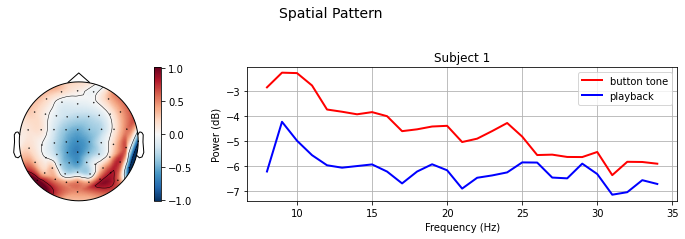

In [14]:
  auc = []  #enumerate for count iterate number
  epochs_tot = []

  #check file is existing on folder
  fnames = glob("/content/gdrive/My Drive/eeg2/input/%d.csv" % (subject))

  fname = fnames[0] 
  session = []
  y = []

  # read data 
  custom_epochs = creat_mne_epoch_object(fname, info)

  # pick eeg signal (mne library)
  picks = pick_types(custom_epochs.info,eeg=True)

  # Filter data for alpha frequency and beta band
  custom_epochs.filter(2,45, picks=picks, method='iir', n_jobs=-1, verbose=False)

  #epoch with condition
  epochs = custom_epochs['button_tone']
  epochs_tot.append(epochs)
  session.extend([1]*len(epochs))
  y.extend([1]*len(epochs))
    
  epochs = custom_epochs['playback_tone']
  epochs_tot.append(epochs)
  session.extend([1]*len(epochs))
  y.extend([-1]*len(epochs))
        
  #concatenate all epochs
  epochs = concatenate_epochs(epochs_tot)

  #get 1second around the tone onset:
  #for debugging: subEpochs = epochs
  X = epochs.crop(tmin=-0.7, tmax=0.299).get_data()
  #but exclude non 'eeg' channels:
  X = X[:,[ch=='eeg' for ch  in ch_type],:]
    
  y = np.array(y)

  # run CSP(특징 추출을위한 공간 필터를 추정하기 위해 감독 분해 (supervised decomposition)로 사용)
  csp = CSP(reg='ledoit_wolf')
  csp.fit(X,y)

  # compute spatial filtered spectrum
  po = []
  for x in X:
    f,p = welch(np.dot(csp.filters_[0,:].T,x), sfreq, nperseg=X.shape[2])
    po.append(p)
  po = np.array(po)

  # prepare topoplot
  _,epos,_,_,_ = _prepare_topo_plot(epochs,'eeg',None)


  #Drawing plot!!
  pattern = csp.patterns_[0,:]
  pattern -= pattern.mean()
  ix = np.argmax(abs(pattern))

  if pattern[ix]>0:
    sign = 1.0
  else:
    sign = -1.0
    
  fig, ax_topo = plt.subplots(1, 1, figsize=(12, 4))
  title = 'Spatial Pattern'
  fig.suptitle(title, fontsize=14)
  img, _ = plot_topomap(sign*pattern,epos,axes=ax_topo,show=False)
  divider = make_axes_locatable(ax_topo)
    # add axes for colorbar
  ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
  plt.colorbar(img, cax=ax_colorbar)
    
    # plot spectrum
  fix = (f>7) & (f<35)
  ax_spectrum = divider.append_axes('right', size='300%', pad=1.2)
  ax_spectrum.plot(f[fix],np.log(po[y==1][:,fix].mean(axis=0).T),'-r',lw=2)
  ax_spectrum.plot(f[fix],np.log(po[y==-1][:,fix].mean(axis=0).T),'-b',lw=2)
  ax_spectrum.set_xlabel('Frequency (Hz)')
  ax_spectrum.set_ylabel('Power (dB)')
  plt.grid()
  plt.legend(['button tone','playback'])
  plt.title('Subject %d' % subject)

  plt.savefig('spatial_pattern_subject_%02d.png' % subject ,bbox_inches='tight')